In [58]:
from typing import Union, List, Dict, Tuple, Callable, Any

import os
import pathlib
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import json
import pickle

import sys
sys.path.append("..")

import tqdm

import numpy as np
import pandas as pd

from scipy.stats import chi2_contingency, wilcoxon

import tensorflow as tf
from pytorch_transformers import RobertaTokenizer

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from src.eqt.datasets import create_test_dataset_for_prediction
from src.eqt.preprocess_data import preprocess_data
from src.eqt.model_qbert import QBERT
from src.eqt.model_utils import create_masks


mappings = {
    'type': {
        'Ask about antecedent':  0,
        'Ask about consequence': 1,
        'Ask for confirmation':  2,
        'Irony':                 3,
        'Negative rhetoric':     4,
        'Positive rhetoric':     5,
        'Request information':   6,
        'Suggest a reason':      7,
        'Suggest a solution':    8,
    },
    'intent': {
        'Amplify excitement': 0,
        'Amplify joy':        1,
        'Amplify pride':      2,
        'De-escalate':        3,
        'Express concern':    4,
        'Express interest':   5,
        'Moralize speaker':   6,
        'Motivate':           7,
        'Offer relief':       8,
        'Pass judgement':     9,
        'Support':           10,
        'Sympathize':        11,
    }
}

class_type = "intent"
peak_lr = 2e-5
checkpoints_path = f"../models/{class_type}"
data_path = "../data/eqt/quest_df_all_labelled_intents.pickle"
restore_epoch = 3 if class_type == "intent" else 4

In [2]:
# Load model checkpoint
num_layers         = 12
d_model            = 768
num_heads          = 12
dff                = d_model * 4
hidden_act         = "gelu"
dropout_rate       = 0.1
layer_norm_eps     = 1e-5
max_position_embed = 514

tokenizer  = RobertaTokenizer.from_pretrained("roberta-base")
vocab_size = tokenizer.vocab_size

lab_mapping  = mappings[class_type]
pred_mapping = {v: k for k, v in lab_mapping.items()}
num_classes  = len(pred_mapping.keys())

adam_beta_1  = 0.9
adam_beta_2  = 0.98
adam_epsilon = 1e-6

qbert = QBERT(num_layers, 
              d_model, 
              num_heads, 
              dff, 
              hidden_act, 
              dropout_rate,
              layer_norm_eps, 
              max_position_embed, 
              vocab_size, 
              num_classes)
optimizer = tf.keras.optimizers.legacy.Adam(peak_lr, 
                                            beta_1=adam_beta_1, 
                                            beta_2=adam_beta_2,
                                            epsilon=adam_epsilon)
ckpt = tf.train.Checkpoint(model=qbert, optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoints_path, max_to_keep=None)
ckpt.restore(ckpt_manager.checkpoints[restore_epoch - 1]).expect_partial()
print('Checkpoint {} restored!!!'.format(ckpt_manager.checkpoints[restore_epoch - 1]))

Checkpoint ../models/intent/ckpt-3 restored!!!


In [3]:
def get_label_source(row, class_tag):
    if row[class_tag] != '':
        return row['label_source']
    return 'QBERT'


def predict(test_dataset):
    
    y_pred = []
    pred_ids = []
    for inputs in tqdm.tqdm(test_dataset):
        inp, weights, ids = inputs
        enc_padding_mask = create_masks(inp)
        pred_class = qbert(inp, weights, False, enc_padding_mask)
        pred_class = np.argmax(pred_class.numpy(), axis=1)
        y_pred += pred_class.tolist()
        y_pred_lab = [pred_mapping[pred] for pred in y_pred]
        pred_labels = np.array(y_pred_lab)
        pred_ids += [idx.decode('utf-8') for idx in ids.numpy()]

    return pred_labels, pred_ids

```
# Load dataset
with open(data_path, 'rb') as f:
    quest_df = pickle.load(f)
    quest_df['{}_source'.format(class_type)] = ''
    quest_df['{}_source'.format(class_type)] = quest_df.apply(get_label_source, axis=1, class_tag=class_type)

data = preprocess_data(data_path, class_type, drop_test=False)
test_dataset = create_test_dataset_for_prediction(tokenizer, data, 32, 256, lab_mapping)
predictions, ids = predict(test_dataset)
```

## __Eval Self-chat Dialogues__

### __Dialogue Preprocessing__

We need to truncate dialogues in terms of both __turns__ and __questions__. Each turn will be separated by a newline character. This is how the EQT `create_test_dataset_for_prediction()` function identifies dialogue turns. Further, since the bot may ask more than one questions in each turn, we need to truncate the dialogues multiple times to have the input dialogue end with each question.

In [4]:
def format_dialogue(
        dialogue: List[Dict[str, str]], 
        sep_char: str = "\n",
        key_content: str = "text"
    ) -> str:
    """Simply concatenate the utterances of dialogue turns with a 
        `sep` character, which defaults to the newline character 
        to conform the EQT provided API."""
    
    ret = sep_char.join(d[key_content] for d in dialogue)
    return ret


def generate_samples_from_dialogue(
        dialogue: List[Dict[str, str]],
        q_predictor: Callable[[str], bool] = None,
        key_content: str = "text",
        key_role: str = "role",
        role_bot: str = "therapist",
    ) -> List[str]:
    """For each input dialogue turns in the form of `List[Dict[str, str]]`,
        generate samples that comply with the EQT inference API."""

    from nltk.tokenize import sent_tokenize
    
    q_predictor = q_predictor or (lambda x: x.endswith("?"))

    ret = []
    for i, d in enumerate(dialogue, start=1):
        if d[key_role] == role_bot:
            dialogue_truncated = dialogue[:i]

            # Generate one sample for each question in 
            #   the bot's utterance
            sentences_bot = sent_tokenize(d[key_content])
            for j, s in enumerate(sentences_bot, start=1):
                if q_predictor(s):
                    d_cp = d.copy()
                    d_cp[key_content] = " ".join(sentences_bot[:j])
                    sample = dialogue_truncated[:-1] + [d_cp]
                    ret.append(format_dialogue(sample, key_content=key_content))
    return ret

In [5]:
path_dial_penalty = "../data/conversations/hackathon-4turn-8dial-w-penalty.json"
path_dial_default = "../data/conversations/hackathon-4turn-8dial-no-penalty.json"

with open(path_dial_penalty, "r") as f:
    data_penalty = json.load(f)

with open(path_dial_default, "r") as f:
    data_default = json.load(f)

all_personas = {d["meta"]["persona_patient"] for d in data_penalty}
all_personas = {s: i for i, s in enumerate(all_personas)}

In [48]:
def make_sample_row(record, config_id) -> Dict[str, Any]:

    meta: Dict = record["meta"]
    dial: List = record["dialogue"]

    ret = {"meta_id": f"{all_personas[meta['persona_patient']]}-{config_id}",
           "utterance_truncated": generate_samples_from_dialogue(dial)}
    return ret


samples_penalty = pd.DataFrame([make_sample_row(d, config_id="penalty") for d in data_penalty])
samples_default = pd.DataFrame([make_sample_row(d, config_id="default") for d in data_default])
samples = pd.concat([samples_penalty, samples_default], axis=0) \
            .explode("utterance_truncated") \
            .reset_index(drop=True) \
            .dropna(subset=["utterance_truncated"]) \
            .reset_index(drop=True)
samples["id"] = samples.index.map(lambda x: f"sample-{x}")
samples

,meta_id,utterance_truncated,id
0,5-penalty,"Hi Hal, I'm feeling really overwhelmed right n...",sample-0
1,5-penalty,"Hi Hal, I'm feeling really overwhelmed right n...",sample-1
2,5-penalty,"Hi Hal, I'm feeling really overwhelmed right n...",sample-2
3,5-penalty,"Hi Hal, I'm feeling really overwhelmed right n...",sample-3
4,5-penalty,"Hi Hal, I'm feeling really overwhelmed right n...",sample-4
...,...,...,...
793,1-default,"Hi Hal, I'm really struggling with the languag...",sample-793
794,1-default,"Hi Hal, I'm really struggling with the languag...",sample-794
795,1-default,"Hi Hal, I'm really struggling with the languag...",sample-795
796,1-default,"Hi Hal, I'm really struggling with the languag...",sample-796


In [49]:
test_dataset = create_test_dataset_for_prediction(tokenizer, samples, 32, 256, lab_mapping)
predictions, ids = predict(test_dataset)

Vocabulary size is 50265.


100%|██████████| 798/798 [00:00<00:00, 901.21it/s]


Created dataset with 798 examples.


100%|██████████| 25/25 [00:14<00:00,  1.76it/s]


In [51]:
df_pred = pd.DataFrame({'id': ids, f'{class_type}_prediction': predictions})
df_pred = pd.merge(df_pred, samples, on='id', how='left')
df_pred["persona_id"] = df_pred["meta_id"].map(lambda x: x.split("-")[0])
df_pred["set_id"] = df_pred["meta_id"].map(lambda x: x.split("-")[1])
df_pred["last_turn"] = df_pred["utterance_truncated"].map(lambda x: x.split("\n")[-1])
df_pred

,id,intent_prediction,meta_id,utterance_truncated,persona_id,set_id,last_turn
0,sample-0,Express interest,5-penalty,"Hi Hal, I'm feeling really overwhelmed right n...",5,penalty,It sounds like you're feeling a lot of pressur...
1,sample-1,Express interest,5-penalty,"Hi Hal, I'm feeling really overwhelmed right n...",5,penalty,I can understand why your parents would want y...
2,sample-2,Express interest,5-penalty,"Hi Hal, I'm feeling really overwhelmed right n...",5,penalty,I can understand why your parents would want y...
3,sample-3,Express interest,5-penalty,"Hi Hal, I'm feeling really overwhelmed right n...",5,penalty,That sounds like a great idea! It's great that...
4,sample-4,Express interest,5-penalty,"Hi Hal, I'm feeling really overwhelmed right n...",5,penalty,That's great that you're taking the initiative...
...,...,...,...,...,...,...,...
793,sample-793,Express interest,1-default,"Hi Hal, I'm really struggling with the languag...",1,default,I'm sorry to hear that you're struggling with ...
794,sample-794,Offer relief,1-default,"Hi Hal, I'm really struggling with the languag...",1,default,I can understand how difficult this must be fo...
795,sample-795,Express interest,1-default,"Hi Hal, I'm really struggling with the languag...",1,default,That's great that you're taking steps to learn...
796,sample-796,Express interest,1-default,"Hi Hal, I'm really struggling with the languag...",1,default,That's great that you're taking steps to learn...


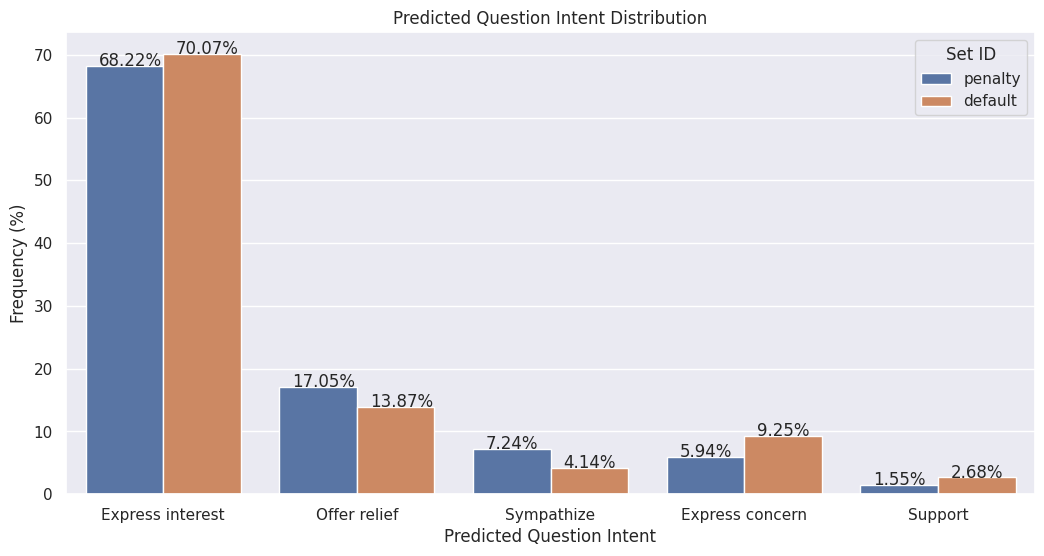

In [52]:
# Plot the distribution (frequency) of question 
#   types by `set_id`
df_vis = df_pred.groupby(["set_id"])[f"{class_type}_prediction"] \
                .value_counts(normalize=True) \
                .rename("percentage") \
                .mul(100) \
                .reset_index() \
                .sort_values(["set_id", "percentage"], ascending=False)

fig, ax = plt.subplots(figsize=(2.5 * df_vis[f"{class_type}_prediction"].nunique(), 6))
sns.barplot(x=f"{class_type}_prediction", 
            y="percentage", 
            hue="set_id", 
            data=df_vis, 
            ax=ax)

ax.set_title(f"Predicted Question {class_type.title()} Distribution")
ax.set_xlabel(f"Predicted Question {class_type.title()}")
ax.set_ylabel("Frequency (%)")
ax.legend(title="Set ID")

for p in ax.patches:
    ax.text(x=p.get_x() + p.get_width() / 6, 
            y=p.get_height(), 
            s=f'{p.get_height().round(2)}%')

## __Statistical Tests__

### __Chi-sq Test for Equal Distribution__

In [53]:
# Chi-square test to compare the distribution of
#   question types between the two sets
df_chisq = df_pred.loc[df_pred[f"{class_type}_prediction"].map(lambda s: not s in {"Express interest", "Request information"})] \
                  .groupby(["set_id"])[f"{class_type}_prediction"] \
                  .value_counts() \
                  .rename("count") \
                  .reset_index() \
                  .pivot(index="set_id", columns=f"{class_type}_prediction", values="count")
df_chisq

intent_prediction,Express concern,Offer relief,Support,Sympathize
set_id,,,,
default,38,57,11,17
penalty,23,66,6,28


In [54]:
# Perform chi-square test
chi2_stat, p_val, dof, expected = chi2_contingency(df_chisq.values)

# Print the results
print("Chi-square statistic:", chi2_stat)
print("P-value:", p_val)
print("Degrees of freedom:", dof)
print("Expected frequencies:", expected)

Chi-square statistic: 8.506538299712794
P-value: 0.036624795189312706
Degrees of freedom: 3
Expected frequencies: [[30.5 61.5  8.5 22.5]
 [30.5 61.5  8.5 22.5]]


### __Wilcoxon Tests for Each Question Intent__

In [55]:
# Wilcoxon signed-rank test to compare whether one combination
#   of decoding parameters results in a different distribution
#   of question intents (or act-types) than the other.
# 
# Perform this test for each intent independently with correction
#   for multiple comparisons. 
all_intents = df_pred[f"{class_type}_prediction"].unique()
all_intents

array(['Express interest', 'Offer relief', 'Support', 'Express concern',
       'Sympathize'], dtype=object)

In [62]:
# Group by intent, set_id, and persona_id
df_wilcoxon = df_pred.groupby([f"{class_type}_prediction", "set_id", "persona_id"]) \
                        .size() \
                        .rename("count") \
                        .reset_index() \
                        .pivot(index=["persona_id"], columns=[f"{class_type}_prediction", "set_id"], values="count") \
                        .fillna(0) \
                        .reset_index()
df_wilcoxon

intent_prediction persona_id Express concern         Express interest          \
set_id                               default penalty          default penalty   
0                          0             5.0     2.0             13.0    19.0   
1                          1             9.0     0.0             29.0    25.0   
2                          2             7.0     9.0             19.0    16.0   
3                          3             0.0     0.0             17.0    23.0   
4                          4             0.0     0.0             39.0    11.0   
5                          5             2.0     0.0             42.0    42.0   
6                          6             0.0     0.0             23.0    27.0   
7                          7             3.0     4.0             38.0    30.0   
8                          8            12.0     8.0             12.0    22.0   
9                          9             0.0     0.0             56.0    49.0   

intent_prediction Offer relief         Support         Sympathize          
set_id                 default penalty default penalty    default penalty  
0                         10.0     9.0     0.0     0.0        1.0     3.0  
1                          6.0     5.0     0.0     1.0        4.0     9.0  
2                          9.0    13.0     0.0     0.0        3.0     3.0  
3                          3.0     5.0     7.0     5.0        0.0     0.0  
4                          2.0     1.0     2.0     0.0        0.0     0.0  
5                          2.0     4.0     0.0     0.0        2.0     0.0  
6                          9.0     9.0     1.0     0.0        4.0     3.0  
7                          3.0     6.0     1.0     0.0        2.0     4.0  
8                         13.0    14.0     0.0     0.0        1.0     6.0  
9                          0.0     0.0     0.0     0.0        0.0     0.0

In [63]:
# Wilcoxon signed-rank test for each intent
for intent in all_intents:
    print(f"Intent: {intent}")
    print("Wilcoxon signed-rank test:")
    print(wilcoxon(df_wilcoxon[intent]["default"], df_wilcoxon[intent]["penalty"]))
    print()

Intent: Express interest
Wilcoxon signed-rank test:
WilcoxonResult(statistic=19.5, pvalue=0.721814730439508)

Intent: Offer relief
Wilcoxon signed-rank test:
WilcoxonResult(statistic=7.5, pvalue=0.13608645140057538)

Intent: Support
Wilcoxon signed-rank test:
WilcoxonResult(statistic=2.0, pvalue=0.12897804299196425)

Intent: Express concern
Wilcoxon signed-rank test:
WilcoxonResult(statistic=3.5, pvalue=0.1411161381713362)

Intent: Sympathize
Wilcoxon signed-rank test:
WilcoxonResult(statistic=4.0, pvalue=0.16700719585656576)



/home/dogdog/.local/lib/python3.9/site-packages/scipy/stats/_morestats.py:3145: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/dogdog/.local/lib/python3.9/site-packages/scipy/stats/_morestats.py:3159: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
